In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet
from manifold_mixup import *
from dynamic_mixup import *
from rlamb import *

In [3]:
GPU = 1
np.random.seed(1773)
MODEL =  EfficientNet.from_pretrained('efficientnet-b7', num_classes=3)
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
BS = 8
SIZE = 512
EXP_NAME = "{}-{}-{}".format(BS, SIZE, exp_time)
TEST_PATH = "/home/ubuntu/crop/data_v1/test"
print(EXP_NAME)

Loaded pretrained weights for efficientnet-b7
8-512-2020-03-22_12:02:00


In [4]:
CSV_PATH = "/home/ubuntu/crop/notebooks/fastai2/Prod/cv{}.csv".format(1)
df = pd.read_csv(CSV_PATH)

In [5]:
df["label"].value_counts()

stem_rust        376
leaf_rust        358
healthy_wheat    142
Name: label, dtype: int64

In [6]:
opt_func = partial(ranger, mom=0.95, sqr_mom=0.99, eps=1e-6)

In [7]:
item_tfms = [Resize(SIZE)]
batch_tfms = [Rotate(), Flip(),  Normalize.from_stats(*imagenet_stats)]

In [8]:
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/crop/data_v3/train", 
                                item_tfms=item_tfms,batch_tfms=batch_tfms,
                                bs=BS, num_workers=16, device=GPU)

Could not do one pass in your dataloader, there is something wrong in it


In [9]:
cbs = [DynamicOutputMixup(scheduler=SchedLin, alpha_max=0., alpha_min=1.)] 
learn = Learner(dls, MODEL, metrics=[error_rate, accuracy], cbs=cbs, opt_func=opt_func).to_fp16()

Scheduler detected, growing alpha from 1.0 to 0.0


In [10]:
learn.freeze()
learn.fit_one_cycle(100, slice(2e-3), cbs=[EarlyStoppingCallback(patience=3), SaveModelCallback(fname=EXP_NAME)])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.072255,1.033688,0.400000,0.600000,01:03
1,0.956195,0.728497,0.177143,0.822857,00:57
2,0.784377,0.390082,0.097143,0.902857,00:56
3,0.648717,0.318963,0.102857,0.897143,00:57
4,0.575175,0.320448,0.074286,0.925714,00:56
5,0.526627,0.339950,0.108571,0.891429,00:57
6,0.536980,0.300858,0.068571,0.931429,00:58
7,0.513580,0.371839,0.137143,0.862857,00:56
8,0.515615,0.330176,0.120000,0.880000,00:57
9,0.526257,0.312692,0.091429,0.908571,00:57


No improvement since epoch 6: early stopping


In [11]:
learn.unfreeze()
cbs_1 = EarlyStoppingCallback(patience=3, min_delta=1e-5, monitor="error_rate")
cbs_2 = SaveModelCallback(fname=EXP_NAME)
learn.fit_one_cycle(100, slice(1e-7, 1e-4), cbs=[cbs_1, cbs_2])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.455634,0.289923,0.074286,0.925714,00:56
1,0.496659,0.281877,0.074286,0.925714,00:56
2,0.488083,0.272524,0.068571,0.931429,00:58
3,0.451690,0.262116,0.068571,0.931429,00:57
4,0.472896,0.256787,0.068571,0.931429,00:57
5,0.447638,0.255135,0.062857,0.937143,00:58
6,0.443173,0.252760,0.068571,0.931429,00:57
7,0.426934,0.250391,0.068571,0.931429,00:57
8,0.425037,0.250741,0.080000,0.920000,00:56


No improvement since epoch 5: early stopping


Output mixup: the loss function is now properly wrapped.


SuggestedLRs(lr_min=1.2589253856276628e-06, lr_steep=6.309573308271865e-08)

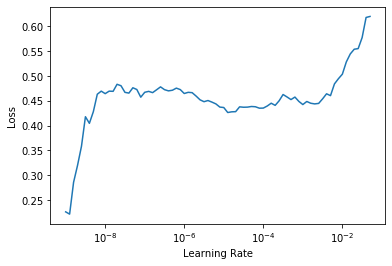

In [12]:
learn.freeze()
learn.lr_find(start_lr=1e-09, suggestions=True)

In [13]:
cbs_1 = EarlyStoppingCallback(patience=3, min_delta=1e-7, monitor="error_rate")
cbs_2 = SaveModelCallback(fname=EXP_NAME)
learn.fit_one_cycle(100, slice(1e-9), cbs=[cbs_1, cbs_2])

Output mixup: the loss function is now properly wrapped.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.443330,0.259385,0.097143,0.902857,00:57
1,0.437014,0.261336,0.068571,0.931429,00:57
2,0.443845,0.296982,0.085714,0.914286,00:56
3,0.491984,0.348057,0.125714,0.874286,00:58
4,0.559331,0.706495,0.234286,0.765714,00:56


No improvement since epoch 1: early stopping


Output mixup: the loss function is now properly wrapped.


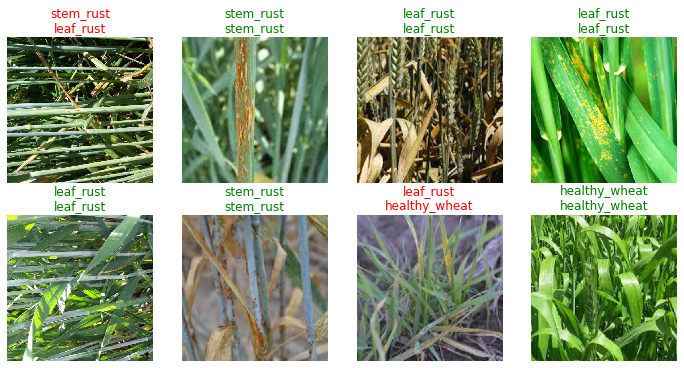

In [14]:
learn.show_results()

Output mixup: the loss function is now properly wrapped.


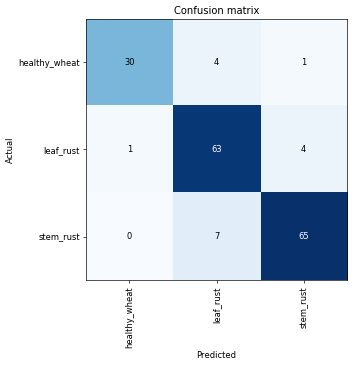

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)

In [16]:
interp.most_confused()

[('stem_rust', 'leaf_rust', 7),
 ('healthy_wheat', 'leaf_rust', 4),
 ('leaf_rust', 'stem_rust', 4),
 ('healthy_wheat', 'stem_rust', 1),
 ('leaf_rust', 'healthy_wheat', 1)]

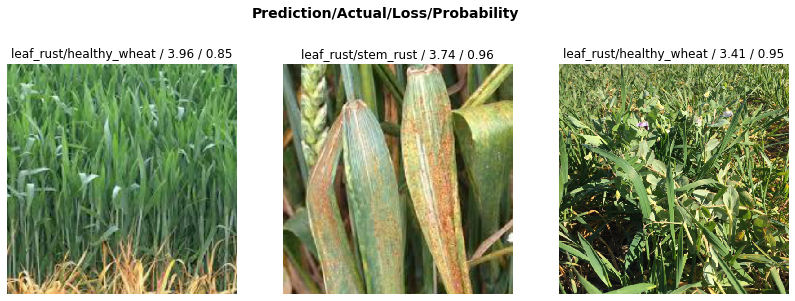

In [17]:
interp.plot_top_losses(3, figsize=(14,5))

In [18]:
ac_1 = learn.validate(); ac_1

Output mixup: the loss function is now properly wrapped.


(#3) [0.25938454270362854,0.09714286029338837,0.9028571248054504]

In [19]:
learn = learn.to_fp32()

In [20]:
learn.save("/home/ubuntu/crop/models/"+EXP_NAME)

In [21]:
path = "/home/ubuntu/crop/data_v1/test"
imgs = get_image_files(path)

In [22]:
test_dl = dls.test_dl(imgs)

In [23]:
preds, _ = learn.get_preds(dl=test_dl)
# preds, tta_targ = learn.tta(dl=test_dl, n=1)

Output mixup: the loss function is now properly wrapped.


In [24]:
ids = [i.split(".")[0] for i in os.listdir('/home/ubuntu/crop/data_v1/test')]
submission = pd.DataFrame({'ID': ids, 'leaf_rust': preds[:,0], 'stem_rust': preds[:,1], 'healthy_wheat': preds[:,2]})
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [25]:
submission.to_csv('/home/ubuntu/crop/submission/{}.csv'.format(EXP_NAME), index=False)